# 1. Intro - imports

In [1]:
! qi login "https://api.quantum-inspire.com"

Please continue logging in by opening: https://auth.quantum-inspire.com/activate?user_code=ZRFR-GHQL in your browser
If promped to verify a code, please confirm it is as follows: ZRFR-GHQL
Login successful!
Using member ID 10


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from qiskit import QuantumCircuit, transpile
from qiskit_quantuminspire.qi_provider import QIProvider
from qi_utilities.utility_functions.circuit_modifiers import apply_readout_circuit
from qi_utilities.utility_functions.raw_data_processing import get_multi_counts, get_multi_probs, observable_expectation_values_Z_basis
from qi_utilities.utility_functions.readout_correction import (split_raw_shots, extract_ro_assignment_matrix, plot_ro_assignment_matrix,
                                                               get_ro_corrected_multi_probs, measure_ro_assignment_matrix)
from qi_utilities.utility_functions.data_handling import StoreProjectRecord, RetrieveProjectRecord

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
provider = QIProvider()

In [4]:
provider.backends()

[<qiskit_quantuminspire.qi_backend.QIBackend object at 0x142c56f60 (name=QX emulator, id=1)>,
 <qiskit_quantuminspire.qi_backend.QIBackend object at 0x140d136b0 (name=Ry emulator, id=5)>,
 <qiskit_quantuminspire.qi_backend.QIBackend object at 0x1428ce7e0 (name=Tuna-9, id=6)>]

In [5]:
backend_name = "Tuna-9"
backend = provider.get_backend(name=backend_name)

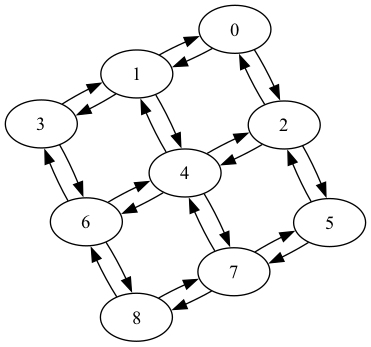

In [6]:
backend.coupling_map.draw()

# 2. VQE workspace

In [7]:
import qiskit.quantum_info as qi
from qi_utilities.algorithms.vqe import construct_hva_circuit, make_ansatz, hardware_efficient_vqe

In [ ]:
nr_qubits = 2
J = 1 # in arbitrary units

In [ ]:
pauli_terms = ['XX', 'YY', 'ZZ']
pauli_coefficients = [J, J, J]

hamiltonian_operator = qi.SparsePauliOp(pauli_terms, pauli_coefficients)
print(hamiltonian_operator)

In [ ]:
qc = construct_hva_circuit(initial_state = '01',
                           hamiltonian = hamiltonian_operator,
                           repetitions = 1)

In [ ]:
qc.draw('mpl')

In [ ]:
qc = construct_hva_circuit(initial_state = '01',
                           hamiltonian = hamiltonian_operator,
                           repetitions = 1)
initial_point = np.random.random(qc.num_parameters)
qc_instance = make_ansatz(qc, initial_point)

In [ ]:
superconducting_basis_gates = ['id', 'z', 's', 'sdg', 't', 'tdg', 'x', 'rx', 'y', 'ry', 'cz', 'delay', 'reset']
qubit_list = [0, 2]

qc_transpiled = transpile(qc_instance,
                          backend,
                          initial_layout=qubit_list,
                          basis_gates=superconducting_basis_gates)

In [ ]:
initial_point

In [ ]:
qc_transpiled.draw('mpl')

In [ ]:
nr_shots = 2**11 # NOTE: adjust accordingly in case the memory limitation of the
                 # readout instruments is exceeded
job = backend.run(qc_transpiled, shots=nr_shots, memory=True)
result = job.result(timeout = 600)
StoreProjectRecord(job)

# Assembling everything

In [8]:
nr_qubits = 2
J = 1 # in arbitrary units

pauli_terms = ['XX', 'YY', 'ZZ']
pauli_coefficients = [J, J, J]
hamiltonian_operator = qi.SparsePauliOp(pauli_terms, pauli_coefficients)

superconducting_basis_gates = ['id', 'z', 's', 'sdg', 't', 'tdg', 'x', 'rx', 'y', 'ry', 'cz', 'delay', 'reset']
qubit_list = [0, 2]

In [9]:
def translate_to_Z_basis(pauli_term: str):

    pauli_term = pauli_term.replace("X", "Z")
    pauli_term = pauli_term.replace("Y", "Z")
    return pauli_term

def calculate_energy(result,
                     hamiltonian,
                     qubit_list,
                     ro_assignment_matrix):
    
    raw_data_shots = result.get_memory()
    raw_data_counts = get_multi_counts(raw_data_shots, len(qubit_list))
    raw_data_probs = get_multi_probs(raw_data_counts)
    ro_corrected_probs = get_ro_corrected_multi_probs(raw_data_probs, ro_assignment_matrix, qubit_list)

    output_energy = 0
    for term_idx in range(len(hamiltonian)):

        pauli_term = hamiltonian[term_idx].paulis[0].to_label()
        pauli_term_in_Z = translate_to_Z_basis(pauli_term)
        observable_value = observable_expectation_values_Z_basis([ro_corrected_probs[term_idx]], pauli_term_in_Z)[0]
        coeff = np.real(hamiltonian[term_idx].coeffs[0])
        output_energy += coeff * observable_value

    print(output_energy)
    return output_energy

In [ ]:
def run_vqe(var_parameters,
            qc_parameterized,
            hamiltonian,
            backend,
            qubit_list,
            basis_gates,
            ro_assignment_matrix,
            nr_shots = 2**11):
    
    qc_instance = make_ansatz(qc_parameterized, var_parameters)
    qc_instance_transpiled = transpile(qc_instance,
                              backend,
                              initial_layout=qubit_list,
                              basis_gates=basis_gates)
    
    job = backend.run(qc_instance_transpiled, shots=nr_shots, memory=True)
    result = job.result(timeout = 600)
    job_record = StoreProjectRecord(job, silent=True)
    output_energy = calculate_energy(result, hamiltonian, qubit_list, ro_assignment_matrix)

    job_dir = f"{job_record.job_dir.parts[-3]}_{job_record.job_dir.parts[-2]}_{job_record.job_dir.parts[-1]}"

    return output_energy

In [11]:
from qiskit_algorithms.optimizers import SPSA

qc_parameterized = construct_hva_circuit(initial_state = '01',
                                         hamiltonian = hamiltonian_operator,
                                         repetitions = 1)
initial_point = np.random.uniform(
    low=-np.pi,
    high=np.pi,
    size=qc_parameterized.num_parameters
)
ro_assignment_matrix = measure_ro_assignment_matrix(backend, qubit_list)

SPSA_optimizer = SPSA(
    maxiter=200,
    perturbation=0.1 * np.pi,
    learning_rate=0.05 * np.pi
)
wrapped_func = SPSA_optimizer.wrap_function(run_vqe,
                             args=(qc_parameterized,
                                   hamiltonian_operator,
                                   backend,
                                   qubit_list,
                                   superconducting_basis_gates,
                                   ro_assignment_matrix))

result = SPSA_optimizer.minimize(wrapped_func,
                                 x0 = initial_point,
                                 bounds=[(-np.pi, np.pi)] * qc_parameterized.num_parameters)

KeyboardInterrupt: 

In [12]:
from datetime import datetime

In [15]:
timestamp = datetime.now()
date_timestamp = timestamp.strftime("%Y%m%d")
project_timestamp = timestamp.strftime("%H%M%S")

In [22]:
backend.max_shots

16384

In [24]:
import json
from pathlib import Path
from datetime import datetime
from qiskit_algorithms.optimizers import SPSA

class VQE:
    
    def __init__(self,
                 qc_parameterized,
                 hamiltonian,
                 backend,
                 qubit_list,
                 basis_gates,
                 nr_shots = 2**11,
                 maxiter = 200,
                 project_name = None):
        
        self.termination_status = False
        self.qc_parameterized = qc_parameterized
        self.hamiltonian = hamiltonian
        self.backend = backend
        self.nr_qubits = len(qubit_list)
        self.qubit_list = qubit_list
        self.basis_gates = basis_gates
        self.nr_shots = nr_shots
        self.maxiter = maxiter
        self.project_name = project_name

        if self.project_name == None:
            self.project_name = f'VQE_{self.nr_qubits}_Qubits'

        self.job_directories = []
        self.var_parameter_list = []
        self.output_energies_list = []

        self.create_project_directory()


    def create_project_directory(self):

        timestamp = datetime.now()
        self.date_timestamp = timestamp.strftime("%Y%m%d")
        self.project_timestamp = timestamp.strftime("%H%M%S")

        self.project_dir = (
            Path.home() / "Documents" / "QuantumInspireProjects" / self.date_timestamp
            / f"{self.project_timestamp}_{self.project_name}"
        )
        self.project_dir.mkdir(parents=True, exist_ok=True)

    def store_project_json(self):
        """
        This instance method stores job (project) related metadata within
        the project directory in a JSON format.
        """
        
        general_dict = {}
        general_dict['Backend info'] = {}
        general_dict['Experiment metadata'] = {}
        general_dict['Experiment data'] = {}

        general_dict['Project name'] = self.project_name
        general_dict['Project timestamp'] = f"{self.date_timestamp}_{self.project_timestamp}"

        general_dict['Backend info']['Backend name'] = self.backend.name
        general_dict['Backend info']['Backend number of qubits'] = self.backend.num_qubits
        general_dict['Backend info']['Backend operations set'] = self.backend.instructions
        general_dict['Backend info']['Backend maximum allowed shots'] = self.backend.max_shots

        general_dict['Experiment metadata']['Hamiltonian operator'] = self.hamiltonian
        general_dict['Experiment metadata']['Qubits used'] = self.qubit_list
        general_dict['Experiment metadata']['Number of shots'] = self.nr_shots
        general_dict['Experiment metadata']['Readout assignment matrix'] = self.ro_assignment_matrix
        general_dict['Experiment metadata']['Optimizer maxiter'] = self.maxiter
        general_dict['Experiment metadata']['Jobs directories'] = self.job_directories

        general_dict['Experiment data']['var_parameters'] = self.var_parameter_list
        general_dict['Experiment data']['output_energies'] = self.output_energies_list

        file_path = (
            Path(self.project_dir)
            / f"project_data_{self.date_timestamp}_{self.project_timestamp}.json"
        )
        with open(file_path, 'w') as file:
            json.dump(general_dict, file, indent=3)

    def make_ansatz(self,
                    var_parameters):
        
        ansatz_circuit = self.qc_parameterized
        ansatz_circuit = self.qc_parameterized.assign_parameters(var_parameters)
        return ansatz_circuit
    
    def translate_to_Z_basis(self,
                             pauli_term: str):

        pauli_term = pauli_term.replace("X", "Z")
        pauli_term = pauli_term.replace("Y", "Z")
        return pauli_term
    
    def calculate_energy(self,
                         result):
    
        raw_data_shots = result.get_memory()
        raw_data_counts = get_multi_counts(raw_data_shots, len(qubit_list))
        raw_data_probs = get_multi_probs(raw_data_counts)
        ro_corrected_probs = get_ro_corrected_multi_probs(raw_data_probs, self.ro_assignment_matrix, self.qubit_list)

        output_energy = 0
        for term_idx in range(len(self.hamiltonian)):

            pauli_term = self.hamiltonian[term_idx].paulis[0].to_label()
            pauli_term_in_Z = self.translate_to_Z_basis(pauli_term)
            observable_value = observable_expectation_values_Z_basis([ro_corrected_probs[term_idx]], pauli_term_in_Z)[0]
            coeff = np.real(self.hamiltonian[term_idx].coeffs[0])
            output_energy += coeff * observable_value

        return output_energy
    
    def cost_function(self,
                      var_parameters):
    
        qc_instance = self.make_ansatz(var_parameters)
        qc_instance_transpiled = transpile(qc_instance,
                                self.backend,
                                initial_layout=self.qubit_list,
                                basis_gates=self.basis_gates)
        
        job = backend.run(qc_instance_transpiled, shots=self.nr_shots, memory=True)
        result = job.result(timeout = 600)
        job_record = StoreProjectRecord(job, silent=True)
        output_energy = self.calculate_energy(result)

        self.job_directories.append(f"{job_record.job_dir.parts[-3]}_{job_record.job_dir.parts[-2]}_{job_record.job_dir.parts[-1]}")
        self.var_parameter_list.append(var_parameters)
        self.output_energies_list.append(output_energy)

        self.store_project_json()
        return output_energy
    

    def run(self):

        initial_point = np.random.uniform(
            low=-np.pi,
            high=np.pi,
            size=self.qc_parameterized.num_parameters
        )
        self.ro_assignment_matrix = measure_ro_assignment_matrix(backend, qubit_list)

        SPSA_optimizer = SPSA(
            maxiter=self.maxiter,
            perturbation=0.1 * np.pi,
            learning_rate=0.05 * np.pi
            )

        self.result = SPSA_optimizer.minimize(self.cost_function,
                                        x0 = initial_point,
                                        bounds=[(-np.pi, np.pi)] * qc_parameterized.num_parameters)
        
        self.termination_status = True